Multigrid implementation of 2D finite difference, nnode_edge = 2**7, omega = 4/5:

* Weighted Jacobi: 3231 iterations, 10m 44.3s
* V-cycle: 14 iterations, 7.6s
* Recursive V-cycle: 14 iterations, 7.5s

When nnode_edge = 2**6, omega = 2/3:

* Weighted Jacobi: 1119 iterations, 19.9s
* V-cycle: 21 iterations, 0.9s
* Recursive V-cycle: 21 iterations, 0.9s

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridFD():
    '''
    Note: the size should be the number of intervals, e.g., 
    there are (n-1)*(n-1) internal grid points if the size is n
    '''
    def __init__(self, size):
        self.size = size
        self.v = np.zeros((size-1)*(size-1))
        self.f = np.zeros((size-1)*(size-1))
        self.A = self.CreateA()

    def IsCoarsest(self):
        return self.size == 2
        
    def BoundaryPadding(self):
        '''Return the 2D matrix of the solution vector'''
        v_pad = self.v.reshape((self.size-1,self.size-1))
        return np.pad(v_pad, pad_width=1) # only consider zero boundary
        
    def CreateA(self):
        '''
        Construct the linear equation system Ax = b for a 2D Poisson problem:
            - u_xx - u_yy = f(x,y), -1<x,y<1
            u(-1,y) = u(1,y) = u(x,-1) = u(x,1) = 0
        ''' 
        h = 2.0/self.size
        stencil = np.array([-1.0/h/h, 4.0/h/h, -1.0/h/h])
        B_temp = np.zeros((self.size+1,self.size+1))
        for i in range(1,self.size):
            B_temp[i,i-1:i+2] = stencil
        B = B_temp[1:self.size,1:self.size] 
        A = np.kron(np.eye(self.size-1),B) # diagonal of the stiffness matrix

        Eye_side = -1./h/h*np.eye(self.size-1)
        A = A + np.kron(np.diag(np.ones(self.size-2),1),Eye_side)
        A = A + np.kron(np.diag(np.ones(self.size-2),-1),Eye_side)
        return A

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        omega = 2/3.
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = omega*np.dot(Dinv,residual) + vprev
        return v

In [3]:
class Multigrid():
    '''
    Define the multigrid problem for 2D
    '''
    def __init__(self, n = 64):

        # Problem parameters
        C = 5.0
        k = 1
        l = 2

        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1)[1:n] # size is n-1
        self.y = np.linspace(-1,1,n+1)[1:n] # size is n-1
        self.xx, self.yy = np.meshgrid(self.x, self.y)
        self.solution = []
        self.u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)  # exact solution

        self.size_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids

        f = np.dot(self.grids[0].A,self.u_exact.reshape(-1))
        self.grids[0].f = f # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = GridFD(self.size_arr[i])
        return grids

    def SizeArray(self):
        size_arr = []
        for i in range(self.L):
            size_arr.append(int(self.n/(2.**i)))
        size_arr = np.array(size_arr)
        return size_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        size = int(np.sqrt(f.shape[0]))
        size_res = int((size-1.)/2.)  # size of the restricted level
        f_2d = f.reshape((size,size))
        f_2d_res = np.zeros((size_res,size_res))

        # down sampling in 2D
        for i in range(size_res):
            for j in range(size_res):
                f_2d_res[i,j] = 1./16.*(4*f_2d[2*i+1,2*j+1]+2*(f_2d[2*i+1,2*j]+f_2d[2*i+1,2*j+2]+f_2d[2*i,2*j+1]+f_2d[2*i+2,2*j+1])+
                                        f_2d[2*i,2*j]+f_2d[2*i,2*j+2]+f_2d[2*i+2,2*j]+f_2d[2*i+2,2*j+2])

        return f_2d_res.reshape(-1)

    def InterpolateOp(self):
        interpolate_op = [None]
        for i in range(1,self.L):
            size_current = self.size_arr[i]
            size_prev = self.size_arr[i-1]
            int_temp = np.zeros((size_prev+1,size_current+1))
            stencil = 1./2.*np.array([1,2,1])
            for j in range(size_current-1):
                int_temp[2*j+1:2*j+4,j+1] = stencil
            interpolate_op.append(int_temp[1:-1,1:-1])
        return interpolate_op

    def Interpolate(self, v):
        '''
        Perform linear interpolation to up sample to previous level
        '''
        size = int(np.sqrt(v.shape[0]))
        size_int = int(size*2+1)  # size of the interpolated level
        v_2d = v.reshape((size,size))
        op = self.InterpolateOp()
        level = np.where(self.size_arr == size+1)[0][0]

        v_temp = np.zeros((size,size_int))
        # up sampling row by row
        for i in range(size):
            v_temp[i,:] = np.dot(op[level],v_2d[i,:])

        # up sampling col by col
        v_2d_int = np.zeros((size_int,size_int))
        for j in range(size_int):
            v_2d_int[:,j] = np.dot(op[level],v_temp[:,j])

        return v_2d_int.reshape(-1)

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return np.linalg.norm(v-self.u_exact.reshape(-1), ord=np.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].Relax(n_sample)
        if(not self.grids[l].IsCoarsest()):
            self.grids[l+1].f = self.Restrict(self.grids[l].f - np.dot(self.grids[l].A, self.grids[l].v))
            self.grids[l+1].v *= 0.
            self.grids[l+1].v = self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(n_sample) 
        return self.grids[l].v

    def plot(self):
        '''Plot the solution vector v in 2D'''
        self.solution = self.grids[0].v
        uu = self.solution.reshape(self.xx.shape)
        fig = plt.figure()
        plt.contourf(self.x,self.y,uu)
        plt.axis('scaled')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.colorbar()


In [4]:
n = 2**6
prob = Multigrid(n)

In [5]:
EPS = 1e-6
n_recV_cycle = 0
u_rec_cycle = np.zeros((n-1)*(n-1))
f_cycle = prob.grids[0].f
e_recV_cycle = prob.Error(u_rec_cycle)
e_arr_recV_cycle = [0,e_recV_cycle]
e_relative_recV = [1]
while (e_recV_cycle>EPS):
    print(e_recV_cycle)
    u_prev = u_rec_cycle
    u_rec_cycle = prob.rec_V_cycle(0,u_rec_cycle,f_cycle)
    e_recV_cycle = prob.Error(u_rec_cycle)
    e_arr_recV_cycle.append(e_recV_cycle)
    e_recV_cycle = np.sqrt(np.sum((u_rec_cycle - u_prev) ** 2)) / np.sqrt(np.sum((u_rec_cycle) ** 2))
    e_relative_recV.append(e_recV_cycle)
    n_recV_cycle += 1

print("Solution converges after ", n_recV_cycle, "V-cycle iterations")

0.10132118364233778
0.01411037391555249
0.00621517174458987
0.003338652024952492
0.0019179053827801447
0.0011393698672393451
0.0006904598292085835
0.00042386065229454696
0.0002625542661262575
0.00016373448676447675
0.00010266396071084256
6.467465690830805e-05
4.0917997306122595e-05
2.5993219716113254e-05
1.6576903077369377e-05
1.0611571087879e-05
6.8173004699306815e-06
4.394476668899983e-06
2.841524698072271e-06
1.842547123004987e-06
1.1977697834431469e-06
Solution converges after  21 V-cycle iterations


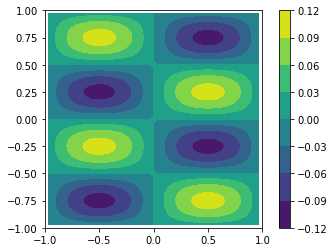

In [6]:
prob.plot()

In [7]:
EPS = 1e-6
n_recV_cycle = 0
u_rec_cycle = np.zeros((n-1)*(n-1))
f_cycle = prob.grids[0].f
e_recV_cycle = prob.Error(u_rec_cycle)
e_arr_recV_cycle = [0,e_recV_cycle]
e_relative_recV = [1]
while (e_recV_cycle>EPS):
    print(e_recV_cycle)
    u_prev = u_rec_cycle
    u_rec_cycle = prob.rec_V_cycle(0,u_rec_cycle,f_cycle)
    e_recV_cycle = prob.Error(u_rec_cycle)
    e_arr_recV_cycle.append(e_recV_cycle)
    e_recV_cycle = np.sqrt(np.sum((u_rec_cycle - u_prev) ** 2)) / np.sqrt(np.sum((u_rec_cycle) ** 2))
    e_relative_recV.append(e_recV_cycle)
    n_recV_cycle += 1

print("Solution converges after ", n_recV_cycle, "V-cycle iterations")

0.10132118364233778
0.01411037391555249
0.00621517174458987
0.003338652024952492
0.0019179053827801447
0.0011393698672393451
0.0006904598292085835
0.00042386065229454696
0.0002625542661262575
0.00016373448676447675
0.00010266396071084256
6.467465690830805e-05
4.0917997306122595e-05
2.5993219716113254e-05
1.6576903077369377e-05
1.0611571087879e-05
6.8173004699306815e-06
4.394476668899983e-06
2.841524698072271e-06
1.842547123004987e-06
1.1977697834431469e-06
Solution converges after  21 V-cycle iterations


In [8]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n-1)*(n-1))
e_jacobi = prob.Error(u_jacobi)
e_arr_jacobi = [0,e_jacobi]
e_relative_jacobi = [1]
while (e_jacobi>EPS):
    print(e_jacobi)
    u_prev = u_jacobi
    prob.grids[0].v = u_jacobi
    u_jacobi = prob.grids[0].Relax(1)
    e_jacobi = prob.Error(u_jacobi)
    e_arr_jacobi.append(e_jacobi)
    e_jacobi = np.sqrt(np.sum((u_jacobi - u_prev) ** 2)) / np.sqrt(np.sum((u_jacobi) ** 2))
    e_relative_jacobi.append(e_jacobi)
    n_jacobi += 1

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

0.10132118364233778
1.0
0.49798944833256176
0.3306562053773812
0.2469922895127681
0.19679610438638995
0.16333378452414404
0.13943367327428363
0.1215099422934495
0.10757046470868185
0.09641996438222522
0.08729781103189534
0.07969691779126271
0.07326622451129079
0.06775497393270083
0.06297927738939135
0.05880121837307571
0.055115331310400875
0.051839587414360296
0.048909227108945165
0.04627244272640061
0.043887294719551856
0.04171946890713263
0.03974061878554993
0.03792712226270782
0.03625913677571379
0.034719872458345485
0.03329502682685826
0.03197234060454865
0.03074124544468409
0.029592582108846986
0.028518373191405915
0.027511638458148673
0.0265662437597095
0.025676776607332828
0.02483844307850637
0.02404698190498874
0.023298592492508534
0.02258987430577421
0.021917775578867187
0.021279549719076196
0.020672718090658414
0.020095038115206295
0.019544475823126146
0.01901918214809707
0.018517472382268835
0.018037808311216583
0.017578782629539897
0.017139105304512
0.01671759160948634
0.01

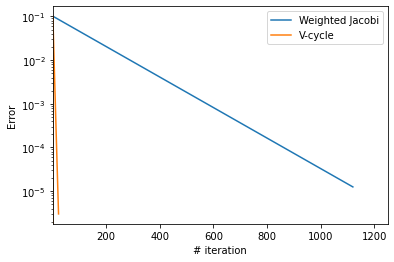

In [9]:
# Plot the error
plt.plot(e_arr_jacobi, label='Weighted Jacobi')
plt.plot(e_arr_recV_cycle, label='V-cycle')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1250])
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()

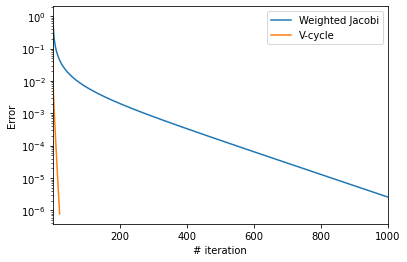

In [10]:
# Plot the relative error
plt.plot(e_relative_jacobi, label='Weighted Jacobi')
plt.plot(e_relative_recV, label='V-cycle')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1000])
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()